# FPP optimization workflow 

In [1]:
using Revise
using FUSE
using IMAS
using Plots;
FUSE.logging(Logging.Info; actors=Logging.Debug);

[ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]


## Make new FPP equilibirum from scratch

### Initialize from FPP v1_demount

In [ ]:
dd = IMAS.dd()
ini, act = FUSE.case_parameters(:FPP, version=:v1_demount, init_from=:scalars);

### Modify ini

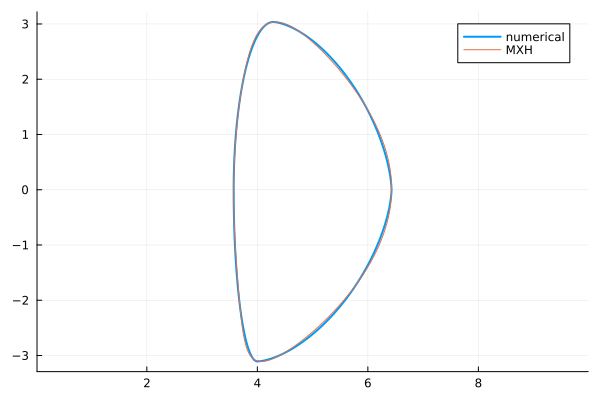

R0: 5.000054394587002
Z0: -0.03571428571428559
ϵ: 0.28570029868693436
κ: 2.150081866970624
c0: 0.05908494541011443
c: [0.0020662945106283107, -0.04615037392491119, 0.00946986222176745, 0.005001486316911282]
s: [0.572275658512161, 0.0800561097049776, -0.02431560307400716, 0.010075266412263034]


172800.0

In [ ]:
ini.equilibrium.R0 = missing # 5.0
ini.equilibrium.B0 = 6.0
ini.equilibrium.ip = 8.5e6
ini.equilibrium.ϵ = missing # 1/3.5
ini.equilibrium.κ = missing # 2.1
ini.equilibrium.δ = missing # 0.6
ini.equilibrium.ζ = 0.0
ini.equilibrium.pressure_core = 1.5e6

ini.build.layers[:hfs_vacuum_vessel] += ini.build.layers[:hfs_vacuum_vessel_wall_inner] + ini.build.layers[:hfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:hfs_vacuum_vessel_wall_outer)
ini.build.layers[:lfs_vacuum_vessel] += ini.build.layers[:lfs_vacuum_vessel_wall_inner] + ini.build.layers[:lfs_vacuum_vessel_wall_outer]
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_inner)
delete!(ini.build.layers,:lfs_vacuum_vessel_wall_outer)

mhx_order = 4
R0 = 5.0
eps = 1/3.5
a = R0*eps
kapu = 2.125
kapl = 2.175
delu = 0.5
dell = 0.7
zetaou = -0.2
zetaol = -0.0
zetaiu = -0.0
zetail = -0.2
upnull = false
lonull = false

r, z, zref = try
    IMAS.boundary_shape(; a, eps, kapu, kapl, delu, dell, zetaou, zetaiu, zetaol, zetail, zoffset=0.0, upnull, lonull)
catch e
    [NaN], [NaN], [NaN]
end

mxh = IMAS.MXH(r, z, mhx_order)
mxh_vect = IMAS.flat_coeffs(mxh)

plot(r, z; aspect_ratio=:equal, lw=2, label="numerical")
display(plot!(mxh,label="MXH"))
display(mxh)

ini.core_profiles.impurity = :Kr
ini.core_profiles.n_shaping = 2.5
ini.core_profiles.T_shaping = 2.5
ini.core_profiles.T_ratio = 0.825
ini.core_profiles.greenwald_fraction = 1.0
ini.core_profiles.ne_ped = missing
ini.core_profiles.greenwald_fraction_ped = 0.67
ini.core_profiles.helium_fraction = 0.04


ini.equilibrium.boundary_from = :MXH_params
ini.equilibrium.MXH_params = mxh_vect
ini.equilibrium.field_null_surface = 0.8
ini.equilibrium.xpoints = :lower

ini.build.plasma_gap = 0.125
ini.build.divertors = :lower
ini.build.symmetric = false

ini.ec_launchers.power_launched = [10e6,20e6]

ini.pf_active.n_coils_outside = 7

ini.requirements.flattop_duration = 48*3600.0

In [ ]:
RiPlasma = R0 - a
ϵ = a/R0

# HFS layers

ini.build.layers[:plasma] = 2*a*(1+ini.build.plasma_gap)
ini.build.layers[:hfs_first_wall] = 0.02
ini.build.layers[:hfs_blanket] = 0.55*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_high_temp_shield] = RiPlasma*0.05
ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.02
ini.build.layers[:hfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:hfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:hfs_gap_low_temp_shield_TF] = RiPlasma * 0.02

rbCenterPost = (R0 - 0.5*ini.build.layers[:plasma] - ini.build.layers[:hfs_first_wall] - ini.build.layers[:hfs_blanket]
    - ini.build.layers[:hfs_high_temp_shield] - ini.build.layers[:hfs_gap_high_temp_shield_vacuum_vessel]
    - ini.build.layers[:hfs_vacuum_vessel] - ini.build.layers[:hfs_gap_vacuum_vessel_low_temp_shield]
    - ini.build.layers[:hfs_low_temp_shield] - ini.build.layers[:hfs_gap_low_temp_shield_TF]);

ini.build.layers[:hfs_TF] = rbCenterPost * 0.25
ini.build.layers[:OH] = rbCenterPost * 0.25
ini.build.layers[:gap_TF_OH] = RiPlasma * 0.02
ini.build.layers[:gap_OH] = rbCenterPost - ini.build.layers[:hfs_TF] - ini.build.layers[:gap_TF_OH] - ini.build.layers[:OH]

# LFS layers

ini.build.layers[:lfs_first_wall] = 0.02
ini.build.layers[:lfs_blanket] = 1.0 - 0.25*((1/ϵ-2.1)/1.9)^0.5
ini.build.layers[:lfs_high_temp_shield] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_high_temp_shield_vacuum_vessel] = RiPlasma * 0.4
ini.build.layers[:lfs_vacuum_vessel] = RiPlasma * 0.05
ini.build.layers[:lfs_gap_vacuum_vessel_low_temp_shield] = RiPlasma * 0.02
ini.build.layers[:lfs_low_temp_shield] = 0.45-0.15*((1/ϵ-1.8)/2.2)^0.5
ini.build.layers[:lfs_gap_low_temp_shield_TF] = RiPlasma * 0.02
ini.build.layers[:lfs_TF] = ini.build.layers[:hfs_TF]

0.4999522355579897

### Modify act

In [ ]:
act.ActorEquilibrium.model = :TEQUILA
act.ActorEquilibrium.symmetrize = false

act.ActorECsimple.rho_0 = [0.0,0.6]
act.ActorECsimple.width = [0.05,0.05]

act.ActorPedestal.update_core_profiles = false
act.ActorPedestal.only_powerlaw = false
act.ActorPedestal.T_ratio_pedestal = 1.0

act.ActorHFSsizing.do_plot = true
act.ActorHFSsizing.verbose = true
act.ActorHFSsizing.j_tolerance = 0.5
act.ActorHFSsizing.stress_tolerance = 0.01
act.ActorHFSsizing.error_on_technology = false
act.ActorHFSsizing.error_on_performance = false
act.ActorFluxSwing.operate_oh_at_j_crit = true

act.ActorPFcoilsOpt.do_plot = true
act.ActorPFcoilsOpt.update_equilibrium = true
act.ActorPFcoilsOpt.weight_lcfs = 1.0
act.ActorPFcoilsOpt.weight_null = 0.1
act.ActorPFcoilsOpt.symmetric = false
act.ActorPFcoilsOpt.optimization_scheme = :none #:rail

act.ActorPowerNeeds.model = :thermal_power_fraction
act.ActorPowerNeeds.thermal_power_fraction = 0.2

act.ActorThermalCycle.power_cycle_type = :fixed_cycle_efficiency
act.ActorThermalCycle.fixed_cycle_efficiency = 0.4

act.ActorStabilityLimits.raise_on_breach = false
act.ActorStabilityLimits.models = [:beta_troyon_1984, :model_201, :model_401] # include βn check

act.ActorCosting.model = :GASC
act.ActorCosting.production_increase = 10.0
act.ActorCosting.learning_rate = 0.616

act.ActorFixedProfiles.T_shaping = ini.core_profiles.T_shaping
act.ActorFixedProfiles.n_shaping = ini.core_profiles.n_shaping
act.ActorFixedProfiles.T_ratio_pedestal = 1.0
act.ActorFixedProfiles.T_ratio_core = ini.core_profiles.T_ratio

act.ActorCoreTransport.model = :FixedProfiles

act.ActorStationaryPlasma.convergence_error = 1e-3
act.ActorStationaryPlasma.max_iter = 10
act.ActorStationaryPlasma.do_plot = true

true

## Run WholeFacility Actor

In [ ]:
dd = IMAS.dd()
@time FUSE.init(dd, ini, act; do_plot=false);
#mxh_plot = plot(dd.equilibrium)
#display(mxh_plot)

[ Info: Equilibrium
[ Info:  TEQUILA
[ Info: HCD
[ Info:  ECsimple
[ Info:  ICsimple
[ Info:  LHsimple
[ Info:  NBsimple
[ Info: SteadyStateCurrent
[ Info: CXbuild


 23.863091 seconds (19.85 M allocations: 6.340 GiB, 3.45% gc time)


[ Info: WholeFacility
[ Info:  StationaryPlasma


Jtor0_before = 7.02 MA/m^2
P0_before = 1694.09 kPa
βn_MHD = 4.16
βn_tot = 3.65
Te_ped = 3.05e+03 eV
rho_ped = 0.9500


[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 7.37 MA/m^2
P0_after = 1694.11 kPa
βn_MHD = 3.82
βn_tot = 3.80
Te_ped = 2.51e+03 eV
rho_ped = 0.9461


[ Info: Iteration = 1 , convergence error = 0.02847, threshold = 0.001
[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 6.92 MA/m^2
P0_after = 1694.11 kPa
βn_MHD = 3.90
βn_tot = 3.81
Te_ped = 2.31e+03 eV
rho_ped = 0.9472


[ Info: Iteration = 2 , convergence error = 0.03372, threshold = 0.001
[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 6.80 MA/m^2
P0_after = 1694.11 kPa
βn_MHD = 3.84
βn_tot = 3.82
Te_ped = 2.30e+03 eV
rho_ped = 0.9483


[ Info: Iteration = 3 , convergence error = 0.00837, threshold = 0.001
[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 6.78 MA/m^2
P0_after = 1694.11 kPa
βn_MHD = 3.80
βn_tot = 3.81
Te_ped = 2.29e+03 eV
rho_ped = 0.9483


[ Info: Iteration = 4 , convergence error = 0.00218, threshold = 0.001
[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 6.81 MA/m^2
P0_after = 1694.11 kPa
βn_MHD = 3.82
βn_tot = 3.81
Te_ped = 2.30e+03 eV
rho_ped = 0.9480


[ Info: Iteration = 5 , convergence error = 0.00209, threshold = 0.001
[ Info:   CoreTransport
[ Info:    FixedProfiles
[ Info:     Pedestal
[ Info:   HCD
[ Info:    ECsimple
[ Info:    ICsimple
[ Info:    LHsimple
[ Info:    NBsimple
[ Info:   Current
[ Info:    SteadyStateCurrent
[ Info:   Equilibrium
[ Info:    TEQUILA



Jtor0_after = 6.80 MA/m^2
P0_after = 1694.11 kPa
βn_MHD = 3.83
βn_tot = 3.81
Te_ped = 2.30e+03 eV
rho_ped = 0.9481


[ Info: Iteration = 6 , convergence error = 0.00068, threshold = 0.001


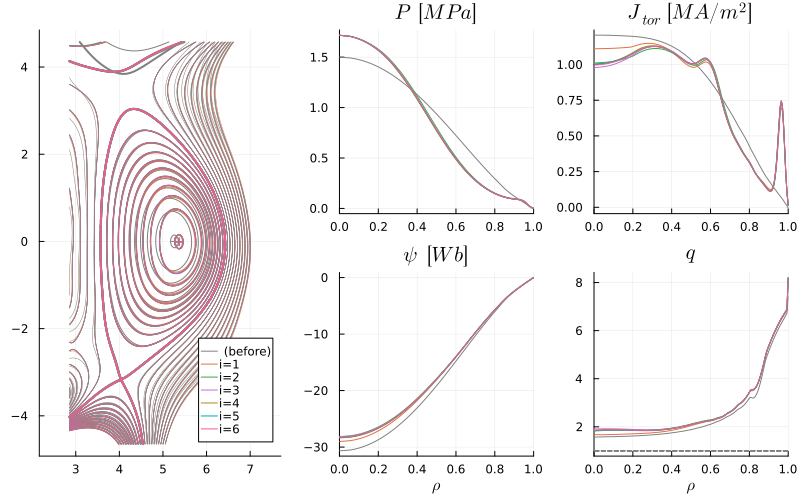

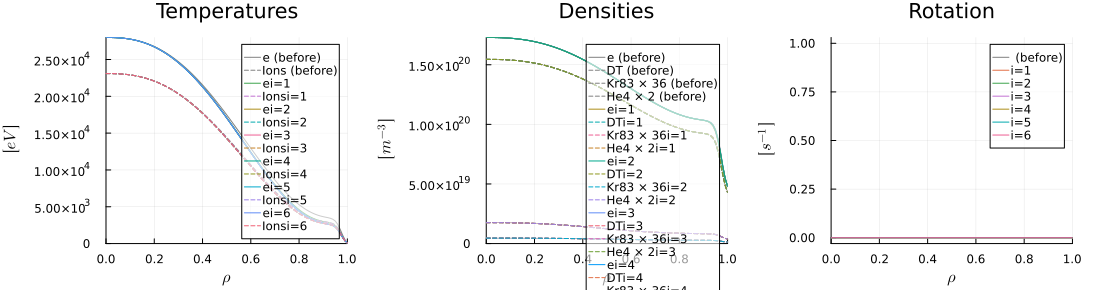

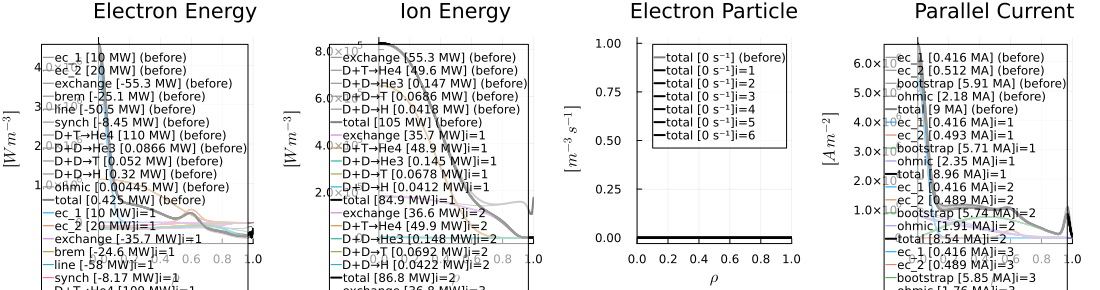

[ Info:  StabilityLimits
[ Info:  HFSsizing
[ Info:   FluxSwing
[ Info:   Stresses


 * Status: success

 * Candidate solution
    Final objective value:     7.815291e-02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    166
    f(x) calls:    305


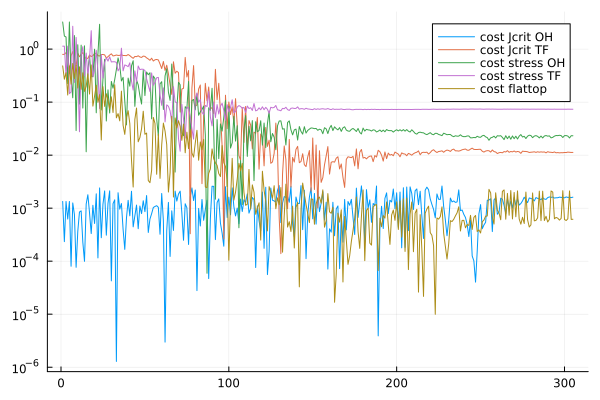

[PL.thickness] = [0.7202656155111715]
[OH.thickness, dd.build.oh.technology.fraction_steel] = [0.7068977887782792, 0.7036459220738441]
[TFhfs.thickness, dd.build.tf.technology.fraction_steel] = [0.501286319874958, 0.8196287650992743]

target_B0 = 6.000061471727675
(dd.build.tf.max_b_field * TFhfs.end_radius) / R0 = 6.000061471727675

dd.build.oh.flattop_duration = 172693.28883431884
dd.requirements.flattop_duration = 172800.0

dd.build.oh.max_j = 2.6937409118346754e7
dd.build.oh.critical_j = 4.034116390719415e7

dd.build.tf.max_j = 2.722851526503256e7
dd.build.tf.critical_j = 4.039017697189292e7

maximum(dd.solid_mechanics.center_stack.stress.vonmises.oh) = 8.102278112358327e8
dd.solid_mechanics.center_stack.properties.yield_strength.oh = 8.0e8

maximum(dd.solid_mechanics.center_stack.stress.vonmises.tf) = 8.482605904122019e8
dd.solid_mechanics.center_stack.properties.yield_strength.tf = 8.0e8

old_R0 / a = 3.1107000641197526
R0 / a = 3.1107000641197526


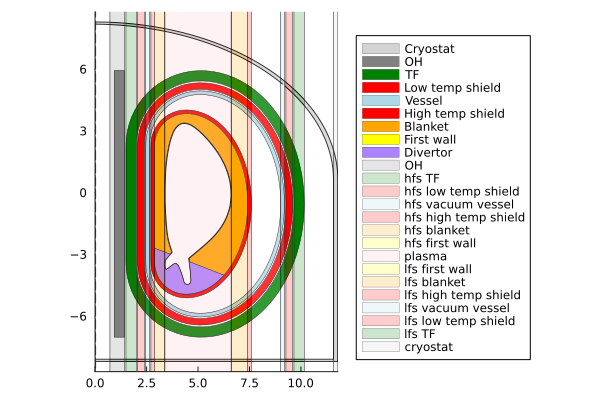

[ Info:  LFSsizing
[ Info:  CXbuild


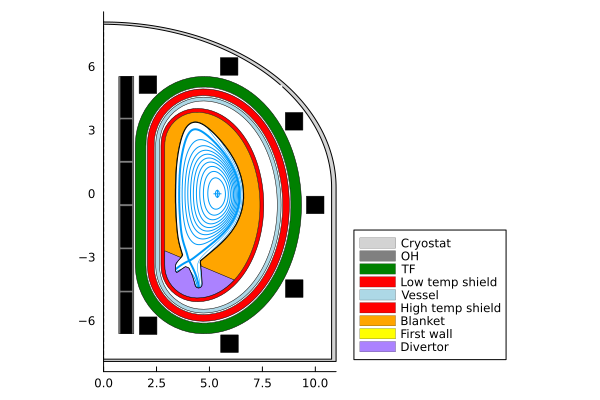

[ Info:  CXbuild


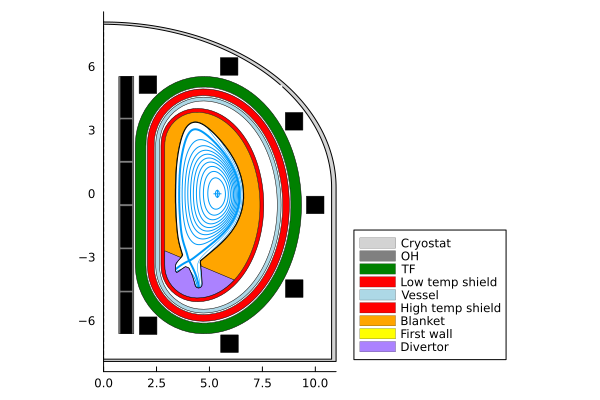

[ Info:  PassiveStructures
[ Info:  Neutronics
[ Info:  Blanket
[ Info:   CXbuild
[ Info:  Divertors
[ Info:  BalanceOfPlant
[ Info:   HeatTransfer
[ Info:   ThermalCycle
[ Info:   PowerNeeds
[ Info:  Costing
[ Info:   GASCCosting


164.480050 seconds (83.78 M allocations: 8.170 GiB, 1.12% gc time, 18.38% compilation time: 26% of which was recompilation)


In [ ]:
@time FUSE.ActorWholeFacility(dd, act);

## Summary

In [ ]:
show(FUSE.timer)

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            21.8h /   0.2%           89.2GiB /  16.3%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 WholeFacility              1     164s   87.3%    164s   8.17GiB   56.3%  8.17GiB
   StationaryPlasma         1     124s   66.0%    124s   5.24GiB   36.1%  5.24GiB
     Equilibrium            6    39.9s   21.2%   6.65s   4.23GiB   29.1%   721MiB
       TEQUILA              6    38.9s   20.7%   6.48s   4.18GiB   28.8%   713MiB
     HCD                    7    2.78s    1.5%   397ms   5.65MiB    0.0%   826KiB
       ECsimple             7   5.54ms    0.0%   791μs    961KiB    0.0%   137KiB
       ICsimple

GEOMETRY                         EQUILIBRIUM                      TEMPERATURES                     DENSITIES                        
─────────────────────────────    ─────────────────────────────    ─────────────────────────────    ─────────────────────────────    
R0 → 5 [m]                       B0 → 6 [T]                       Te0 → 28 [keV]                   ne0 → 1.73e+20 [m⁻³]             
a → 1.43 [m]                     ip → 8.7 [MA]                    Ti0 → 23.1 [keV]                 ne_ped → 9.58e+19 [m⁻³]          
1/ϵ → 3.5 [m]                    q95 → 6.1                        <Te> → 11.6 [keV]                <ne> → 1.26e+20 [m⁻³]            
κ → 2.15                         <Bpol> → 0.726 [T]               <Ti> → 9.88 [keV]                ne0/<ne> → 1.38                  
δ → 0.537                        βpol_MHD → 2.48                  Te0/<Te> → 2.4                   fGW → 1.05                       
ζ → -0.114                       βtor_MHD → 0.0387                Ti0

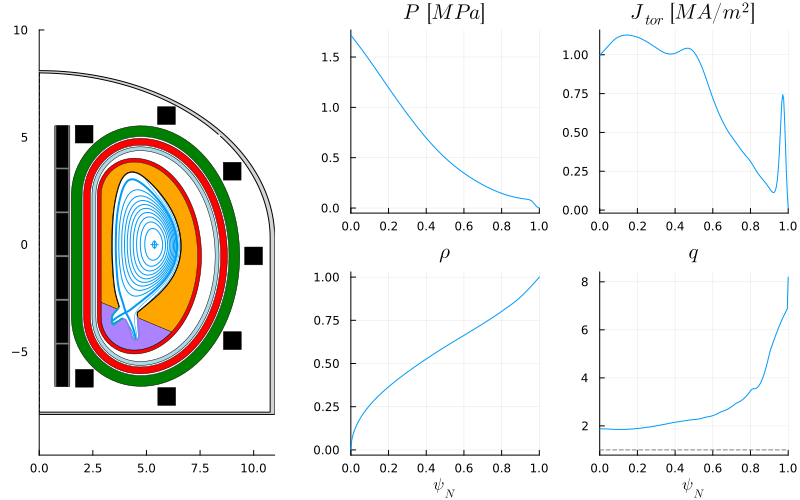

​


24×9 DataFrame
 Row │ group   details     type      ΔR         R_start    R_end      material      area       volume     
     │ String  String      String    Float64    Float64    Float64    String        Float64    Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                            0.720266    0.0        0.720266                 8.74926     19.7977
   2 │ in                  oh        0.706898    0.720266   1.42716   ReBCO          8.58688     57.9301
   3 │ in                            0.0714311   1.42716    1.49859                  0.867694     7.97544
   4 │ hfs                 tf        0.501286    1.49859    1.99988   ReBCO         15.6011     196.038
   5 │ hfs                           0.0714311   1.99988    2.07131                  2.14821     69.1387
   6 │ hfs     low temp    shield    0.318154    2.07131    2.38947   Steel          8.93427    287.949
   7 │ hfs                         

​


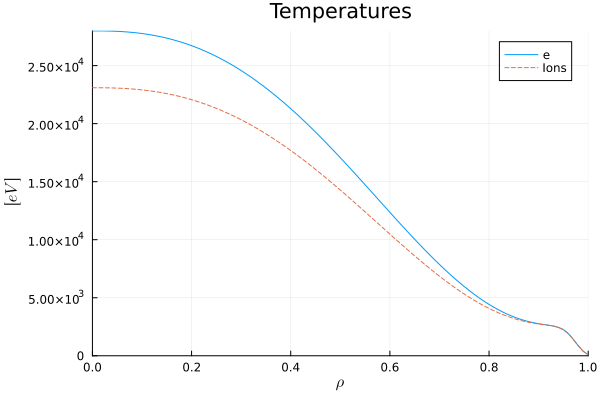

​


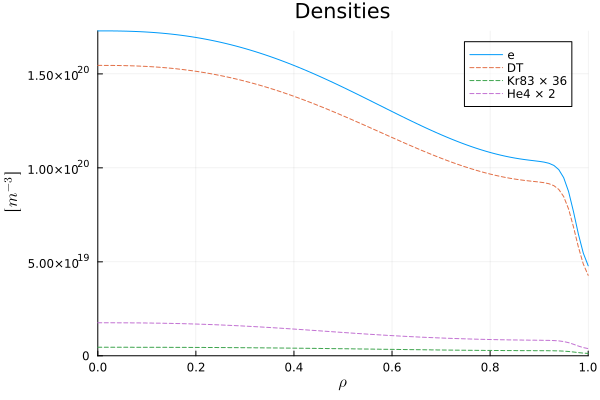

​


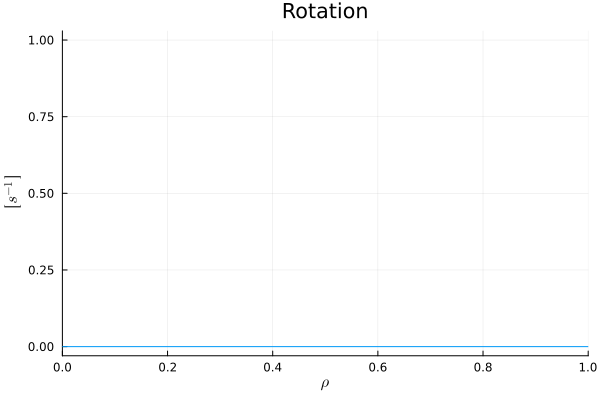

​


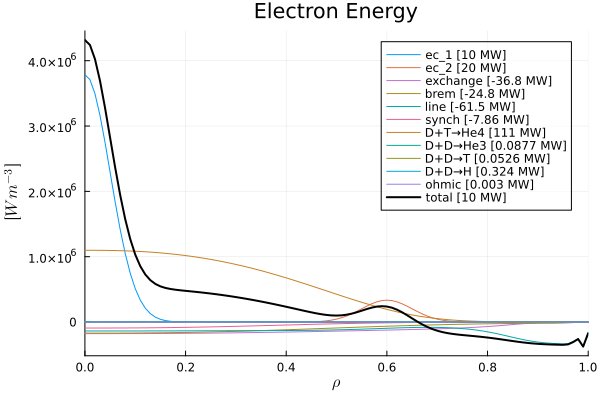

​


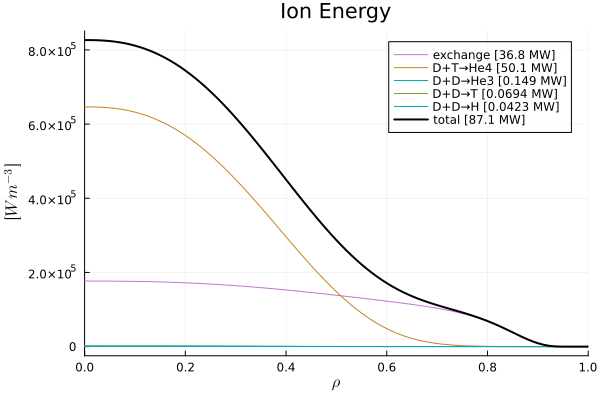

​


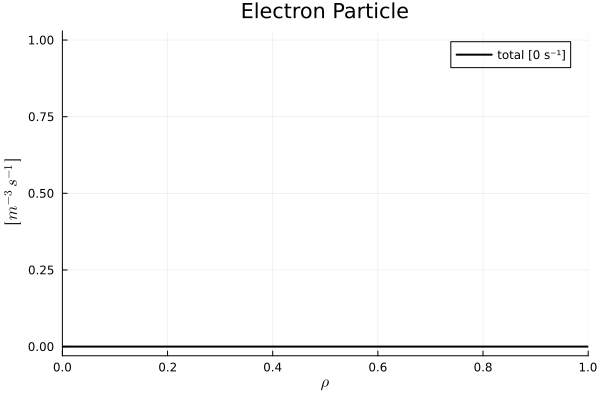

​


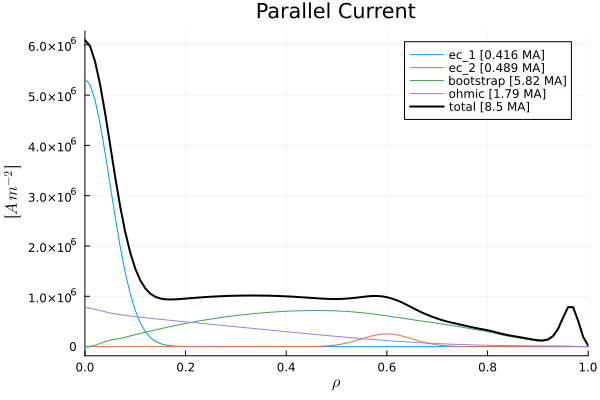

​


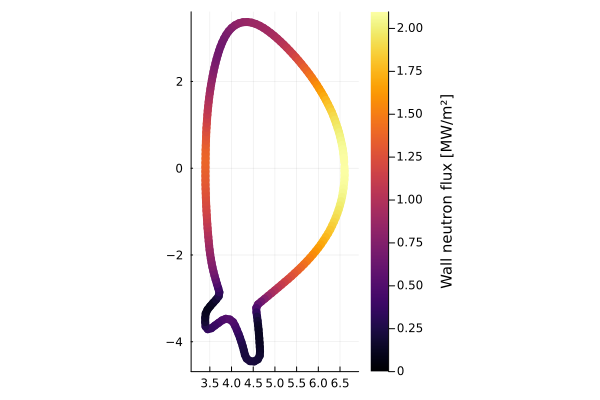

​


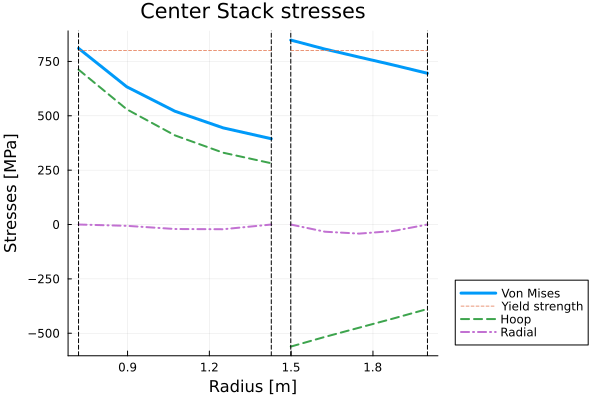

​


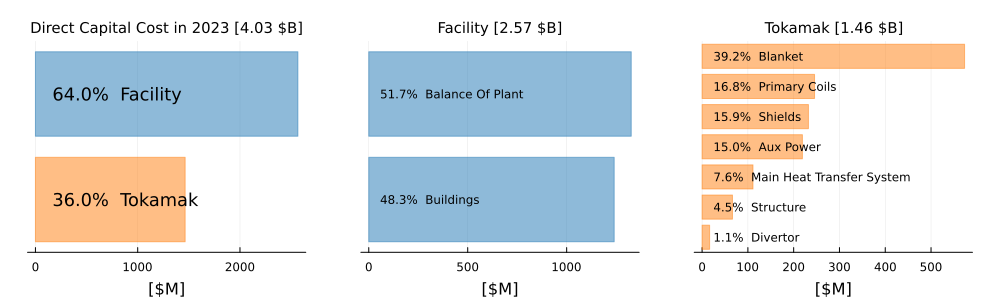

In [ ]:
FUSE.digest(dd)

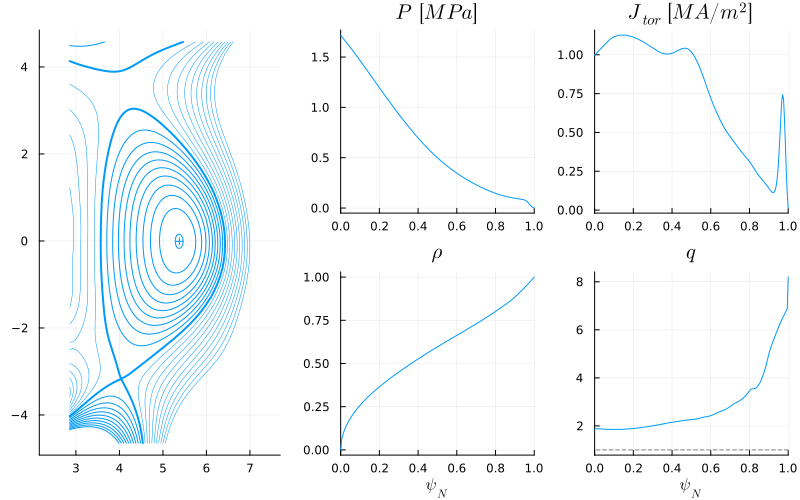

In [ ]:
plot(dd.equilibrium)

In [ ]:
savedir = "/home/weisbergd/julia_dev/FUSE/playground/weisberg_FPP_build/FPP_build_TEQUILA_MXH/"
FUSE.save(savedir,dd,ini,act)

"/home/weisbergd/julia_dev/FUSE/playground/weisberg_FPP_build/FPP_build_TEQUILA_MXH/"

profiles_1d
├─ current_parallel_inside ➡ 101-element Vector{Float64} [A]
├─ electrons
│  ├─ energy ➡ 101-element Vector{Float64} [W.m^-3]
│  ├─ particles ➡ 101-element Vector{Float64} [m^-3.s^-1] (all 0.0)
│  ├─ particles_inside ➡ Function [s^-1]
│  └─ power_inside ➡ 101-element Vector{Float64} [W]
├─ grid
│  ├─ area ➡ 101-element Vector{Float64} [m^2]
│  ├─ psi ➡ Function [Wb]
│  ├─ psi_norm ➡ Function
│  ├─ rho_tor_norm ➡ 101-element Vector{Float64}
│  ├─ surface ➡ 101-element Vector{Float64} [m^2]
│  └─ volume ➡ 101-element Vector{Float64} [m^3]
├─ j_parallel ➡ 101-element Vector{Float64} [A.m^-2]
├─ momentum_tor ➡ 101-element Vector{Float64} [kg.m^-1.s^-2] (all 0.0)
├─ time ➡ 0 [s]
├─ torque_tor_inside ➡ Function [kg.m^2.s^-2]
├─ total_ion_energy ➡ 101-element Vector{Float64} [W.m^-3]
└─ total_ion_power_inside ➡ 101-element Vector{Float64} [W]


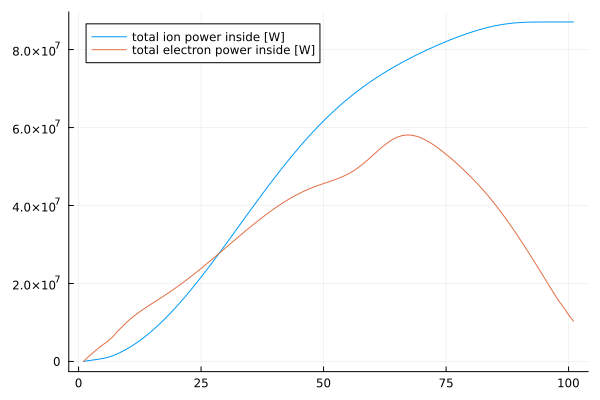

In [ ]:
ts = IMAS.total_sources(dd.core_sources, dd.core_profiles.profiles_1d[],)

display(ts)

plot(ts.total_ion_power_inside,label="total ion power inside [W]")
plot!(ts.electrons.power_inside,label="total electron power inside [W]")